# ASTRO 30400 - Galaxies

## Problem Set 1

### Student : Dimitrios Tanoglidis

### Problem 1 - Milky Way Analogues

a) Select nine (or more) images of randomly drawn galaxies nearest to the Milky Way in half-light radius, $r_{50}$, $r$-band absolute magnitude, $M_r$, and $g-r$ color (see values in the next two exercises) and output their images in a collage. You can use example above showing how to create a collage of random galaxy images, but modify it to select galaxies close to the Milky Way instead of random. The best results will be obtained if you limit the galaxy sample from which you draw to within a maximum distance of $\sim 100-200$ Mpc; you may also play with other restrictions on the sample to optimize your results. 

(b) Examine images of these objects that could ostensibly be considered as the Milky Way analogues and describe their morphology. Briefly discuss any similarities and differences that you notice between different galaxies. How close are the selected galaxies to the Milky Way morphology, which you can see in Figure 2 of the ARAA review of Bland-Hawthorn and Gerhard (2016) on the Milky Way properties in the context of the overall galaxy population. The images are originall from Efremov (2011).

Select your favorite collage of the Milky Way analogues that matches the Milky Way morphology best and present it as part of your solutions to this exercise along with discussion of which parameters work best for this. 



### Solution

First of all let's import and run the part of the code that importsallows us to read the SDSS Data / fits files , import matplot lib and numpy , select a number of galaxies and define parameters as petrosian radii, magnitudes and distances.

In [189]:
# setup notebook for inline figures
%matplotlib inline
import matplotlib.pyplot as plt

from code.plot_utils import plot_pretty
plot_pretty()

In [190]:
# %load code/read_sdss_fits.py
import os
import numpy as np

def read_sdss_fits(data_file=None):
    """Loader for SDSS Galaxies w
    
    Returns
    -------
    data : recarray, shape = (327260,)
        record array containing pipeline parameters


    """
    # pyfits is an optional dependency: don't import globally
    import pyfits

    if not os.path.exists(data_file):
        print "***error! data file",data_file," does not exist!"
        return 0
    hdulist = pyfits.open(data_file)
    return np.asarray(hdulist[1].data)

In [191]:
from code.read_sdss_fits import read_sdss_fits
from code.setup import data_home_dir

# read fits file with the SDSS DR8 main spectroscopic sample
data = read_sdss_fits(data_home_dir()+'SDSSspecgalsDR8full.fit')

In [192]:
import numpy as np

# lower limit on z is to avoid the nearest galaxies for which SDSS pipeline often does not perform well (splitting them into pieces, etc)
# with z_min=0.005 we are excluding galaxies closer than the Virgo cluster ~16 Mpc away from the Milky Way
# z_max=1.0 is to avoid misclassified objects that appear as very high z systems
z_min = 0.005; z_max = 1.0

# SDSS DR8 solid angle in steradians, the solid angle of the SDSS spectroscopic survey is 9274 square degrees, see:
# https://www.sdss3.org/dr8/scope.php
solid_angle = 9274.*(np.pi/180)**2

# magnitude cuts appropriate for the SDSS main spectroscopic sample 
m_min = 14.0; m_max = 17.77
# correct r-band Petrosian magnitudes for Galactic extinction before applying magnitude cuts
mr = data['petroMag_r'] - data['extinction_r']
gr = data['cmodelMag_g'] - data['cmodelMag_r']
# redshift cut and magnitude cuts
data = data[(data['z'] > z_min) & (data['z'] < z_max) & (mr > m_min) & (mr < m_max) & (gr>-0.5) & (gr<2.5)]

# first let's compute some things for the entire z- and magnitude limited sample
# g-r color in model mags
gr = data['cmodelMag_g'] - data['cmodelMag_r']
mcmodel = data['cmodelMag_r']
r50 = data['petroR50_r']; z = data['z']; ext = data['extinction_r']
r90 = data['petroR90_r']
conc = r90/r50
# extinction-corrected surface brightness using Petrosian magnitude and half-light radius
mpetro = data['petroMag_r'] - ext
sb = mpetro - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(r50)**2)

print "selected %d galaxies"%np.shape(sb)
# now compute distances and maximum comoving volume out to which galaxy would be detectable
from colossus.cosmology import cosmology

# set cosmology to the best values from 9-year WMAP data
cosmo = cosmology.setCosmology('WMAP9')

# compute luminosity and angular diameter distances
d_L = cosmo.luminosityDistance(z)/cosmo.h
d_A = d_L/(1.+z)**2

# absolute magnitude in the r-band; apply +1.3*z correction for evolution (see Bernardi et al. 2010)
# and k-correction using polynomial approximations of Chilingarian et al. 2010
# see http://kcor.sai.msu.ru/getthecode/
from code.calc_kcor import calc_kcor 
# this k-correction is not designed for z>0.6, so limit the z for correction calculation
ihz = [z>0.6]; zk = np.copy(z); zk[ihz] = 0.6
kcorr = calc_kcor('r', zk, 'g - r', gr)

# absolute magnitude in the r-band, accounting for extinction, evolution and K-correction
Mcmodel = mcmodel - 5.0*np.log10(d_L/1e-5) - ext + 1.3*z - kcorr 
Mpetro = mpetro - 5.0*np.log10(d_L/1e-5) + 1.3*z - kcorr

# r-band luminosity in Lsun,r from the cmodel and Petrosian absolute mmagnitudes
Lcmodel =  0.4*(4.67-Mcmodel); Lpetro =  0.4*(4.67-Mpetro)

# the sample magnitude limit is defined using Petrosian magnitude, so this is what we need to use to compute Vmax
# we need to compute at what distance this galaxy would have limiting magnitude mlim, 
# then compute Vmax using this distance, assuming flat cosmology (not a big deal at these low z): Vmax=d_M^3(z); d_M=d_L/(1+z) 
d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mpetro))/(1.+z)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mpetro))/(1.+z)

# inverse Vmax comoving volume to be used as weights in distribution histograms
vmaxi = 3.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
# magnitude dependence approximates results of Montero-Dorta & Prada 2009
cc = 0.93 #*(mpetro/17)**(0.5)
# final 1/Vmax
vmaxi = vmaxi / (solid_angle*cc)



selected 646812 galaxies


Now, we have to create a collage of galaxies with properties closest to those of the Milky Way - Milky way analogues (similar half-light radius, $r$-band absolute magnitude and color $(g-r)$).

We get the values for these properties of the MW from problems 2 and 3. We have:

$ r_{50,MW} \sim 4.4 \pm 0.2$ kpc,

$ M_r - 5\log_{10} h  = -20.97 \pm 0.38$,

$(g-r)_{MW} = 0.678_{-0.057}^{+0.069}$

For the parameter $h$, where needed, we will use the value $0.705$ used in older data releases of the SDSS.

We will choose galaxy analogues, by imposing appropriate restrictions (related to the above parameters) to the total sample of galaxies. 

For the absolute magnitude choose minimum and maximum values ~ 2$\sigma$ from the mean. Taking $h=0.705$, the mean value is $M_r \sim -21.72$. For the error, we have to propagate the uncertainties, so the total error will be:
\begin{equation}
\left(\frac{\delta M_r}{M_r} \right)^2 = \left(\frac{\delta h}{\ln 10 h}\right)^2 + \left(\frac{0.38}{20.97}\right)^2 
\end{equation}

Assuming a $10 \%$ uncertainty ($\delta h / h = 0.1$) we have:
$\delta M_r = 0.99$, so:

$M_{r,MW} = - 21.72 \pm 0.99$. 

The limits in $(g-r)$ color will be more strict, $1\sigma$ from the mean value of the MW.

We must also be careful for the case of $r_{50,MW}$. The value in the SDSS catalogue is in (arcsec)$^2$, while above we have the value in kpc. We must tranform the size from arcsec to kpc and impose the $2\sigma$ restriction there.

$ D_A = \frac{ r_{50}(actual\,\,size)}{ r_{50}(angle)} \Rightarrow r_{50}(actual\,\, size) = r_{50}(angle)\times D_A$.

We must be careful when using this formula. First of all, we have used the small angle aproximation, which is correct when angles measured in radians. So, we have to convert arcsecs to radians, using: 1 arcsec = $4.84814 \times 10^{-6}$ radians.

Second, the angular diameter distance is calculated in Mpc, while the the size for the MW is in kpc. We must carefully account for that.

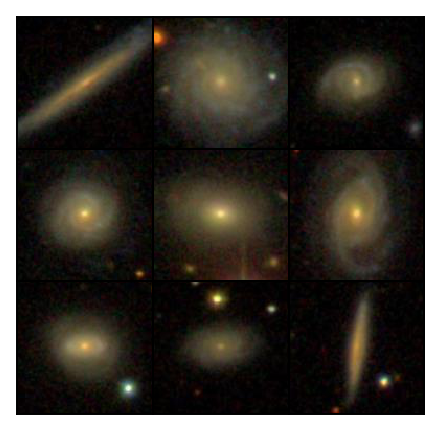

In [193]:
from code.plot_utils import sdss_img_collage

# the number of rows and columns in the image collage
nrow = 3; ncol = 3
# pixel size of the thumbnails to extract from the SDSS
npix = 130

# definition of arcsec 
arcsec = 4.84814e-6


# minimum and maximum luminosity distances for galaxy selection
Dmin = 20.; Dmax = 200.; 
# Limits on absolute r magnitude, color, r_50 -- with proper adjustments, as described above 
Mup = - 19.74
Mlow = - 23.70
grmin = 0.621 
grmax = 0.74
r50min = 4.0
r50max = 4.8


r50 = (r50*arcsec*d_A)*1000



# select galaxies with these distance and absolute magnitude limits
rdata = data[(Mcmodel < Mup) & (Mcmodel > Mlow) & (d_L > Dmin) & (d_L < Dmax) & (gr > grmin) & (gr < grmax) & (r50 > r50min) & (r50 < r50max)]
# select a random subset of galaxies from the selected subset
iran = np.random.randint(0., np.size(rdata)-1, nrow*ncol)
# get data for the randomly selected galaxies
dshow = rdata[iran]
objs = dshow['objID']; ras = dshow['ra']; decs = dshow['dec']

# get images (if they are not yet on disk) and display the collage 
sdss_img_collage(objs, ras, decs, nrow, ncol, npix, scale=0.35)

The photos we get are photos of spiral galaxies. In this run we can't see a spiral with central bar, but in other runs we can also find such galaxies. We get mostly red-yellow (not blue) galaxies with quite bright bulges.

### Problem 2 - Surface Brightness of the Milky Way

The Milky Way half-light radius is $R_{50,\rm MW}\approx 4.4\pm 0.2\ \mathrm{kpc}$. For example, Licquia & Newman (2016) estimate the scale length of the Milky Way disk to be $R_{d,\rm MW}=2.63\pm 0.13$ kpc and that $\approx 85\%$ of the stellar mass in the exponential disk. We can thus estimate the half-mass radius as $r_{50}\approx 1.678\, R_{\rm d}$ (see S 1.3.1 in the class notes). Absolute $r$-band luminosity of the Milky Way is estimated to be $M_{r,\rm MW}-5\log_{10}h=-20.97\pm 0.38$ (see Table 7 in Licquia & Newman (2016)). Compute the $r$-band surface brightness of the Milky Way within $r_{50}$ in magnitudes per square arcsecond, as it would be seen by an extragalactic observer (and show how you did it in intermediate steps). 



### Solution

By definition, surface brightness in units of mag per square arcseconds is given by:

$\mu_r = -2.5\log_{10} f_r/d\Omega $ + const. 

In our case $d\Omega = \pi r_{50,MW}^2$, the half-light radius of the Milky Way (in arcseconds). Thus $f =1/2\times f_{total}$ and we can write:

$\mu_r = -2.5\log_{10} f_{r,total} -2.5\log_{10}(1/2) +const + 2.5\log_{10}(\pi r_{50}^2)$.

But the quantity $ -2.5\log_{10} f_{r,total} + const$ is the apparent magnitude $m_r$. Thus, we can rewrite the above as:

$\mu_r = m_r +2.5\log_{10}2 + 2.5\log_{10}(\pi r_{50}^2)$.

Now, we know the absolute r-band luminosity (magnitude) of the MW, which is conected to the aparent r-band magnitude as:

$\displaystyle m = M + 5\log_{10}\left( \frac{d_L}{10pc} \right) = M +2.5\log_{10} \left(\frac{d_L^2}{10_{pc}^2} \right)$.

So, using this, we can rewrite the surface brightness as:

$\displaystyle \mu_r = M_r + 2.5\log_{10}2 + 2.5 \log_{10}\frac{d_L^2 \pi r_{50}^2}{10_{pc}^2}$.

But the radius $r_{50}$ in the above relation is in arcsecs, while we have the corresponding radius in kpc.

These are related of course, through the angular diameter distance:

$\displaystyle d_A = \frac{r_{50}(kpc)}{r_{50}(radiants)} \Rightarrow r_{50}(radiants) = \frac{r_{50}(kpc)}{d_A}$

Where we have expressed the angular size in radians, since we used the small angle approximation which is valid only when we measure angles in radians. Now, 1 rad $\sim 206264.8$ arcsec , so:

$\displaystyle r_{50}(arcsec) = \frac{r_{50}(kpc)}{d_A}\times 206264.8  $

So, expressing the half-radius not in arcseconds, but in kpc, we have:

$ \displaystyle \mu_r = M_r + 2.5\log_{10}2 +2.5 \log_{10}\left(\frac{d_L^2}{d_A^2}\frac{\pi r_{50}^2(kpc)}{10_{pc}^2}\times 206264.8^2\right)$.

There is a last step left. The luminosity distance and angular diameter distance are related as:

$ d_L = (1+z)^4 d_A$.

Giving the final formula for the \textbf{surface brightness}:

\begin{equation}
\displaystyle \boxed{  \mu_r = M_r +2.5\log_{10}2 + 2.5 \log_{10}\left(\frac{\pi r_{50}^2(kpc)}{10_{pc}^2}\times 206264.8^2\right) +10\log_{10}(1+z)}
\end{equation}

The last term is responsible for the dimming. Here we will ignore that term, assuming that the obsever of the milky way is in a (cosmologically) close distance. Of course, we can trivially then calculate the surface brightness of MW for an observer at an arbitrary redshift $z$, by just adding the last parameter. Anyway, we consider as the surface brightness the quantity:

\begin{equation}
\displaystyle \boxed{  \mu_r = M_r +2.5\log_{10}2 + 2.5 \log_{10}\left(\frac{\pi r_{50}^2(kpc)}{10_{pc}^2}\times 206264.8^2\right)}
\end{equation}

We now everything now. Again, from the previous exercise, we have:

$M_r=−21.72\pm0.99$

and 

$r_{50} \cong 4.4 \pm 0.2$ kpc.

For the Milky Way.
By propagating the uncertainties in $M$ and $r$ (using the usual partial derivative method), we can calculate the uncertainty in the determinatin of the surface brightness. The answer (formula) is:

\begin{equation}
\boxed{ \displaystyle \delta \mu_r = \sqrt{(\delta M)^2+\left(\frac{5}{\ln 10}\frac{\delta r_{50}}{r_{50}}\right)^2}}
\end{equation}

Let's write now a script in order to get numerical values for these quantities, given by the last two formulae:

In [194]:
import numpy as np

Mr = -21.72
deltMr = 0.99

# I will avoid to name my r_50 parameter simply r50, because that has been defined above for the SDSS data. So I name it r50loc -local
#express everything in parsec

r50loc = 4.4e3
deltr50loc = 0.2e3

#name the big numerical value 

num =np.power(206264.82,2)

#let's calculate surface brightness first

surfb = Mr + 2.5*np.log10(2)+2.5*np.log10((np.pi*np.power(r50loc,2))*num/100.0)

# and let's also calculate the error 

deltsurfb = np.sqrt(np.power(deltMr,2)+np.power((5.0/np.log(10))*(deltr50loc/r50loc),2))

#And let us print them:

print("Surface brightness for the Milky Way is:")
print(surfb)

print("And the error is:")
print(deltsurfb)

Surface brightness for the Milky Way is:
20.064838864
And the error is:
0.994908206681


### Problem 3 - Milky Way's place in the realm of galaxies

a) Use the script that produced $g-r$ vs $M_r$, $(g-r)-c_r$, $\mu_r-M_r$ for the entire galaxy sample in the notebook above as an example to make your own similar plot. Add the point with error bars for the Milky Way to these diagrams: $(g-r)$ color of the Milky Way is estimated to be $(g-r)_{\mathrm{MW}}=0.678^{+0.069}_{-0.057}$, while $M_r$ is given in the previous exercise (see Table 7 in Licquia & Newman (2016)). You have to figure out how to compute $c_r$ given the information given above. Discuss location of the Milky Way relative to other galaxies in the diagrams. (5 points)

(b) Does appearance of galaxies in exercise 1 above change significantly, if you add the light concentration, $c_r$, as an additional constraint to select Milky Way analogues? What if you use it instead of one of the quantities used in 1: $M_r$, $g-r$, or $r_{50}$? (2 points) 


### Solution 

From previous problems we have mean values and uncertainties for $r$-band absolute magnitude, surface densiry and $(g-r)$ color of the Milky Way. Let us review them here:

$M_r = -21.72 \pm 0.99$

$\mu_r = 20.06 \pm 0.99$

$(g-r) = 0.678_{-0.057}^{+0.069}$

We have now to compute the concentration of galaxy light:

\begin{equation}
\displaystyle c_r = \frac{R_{90,r}}{R_{50,r}}
\end{equation}

For $R_{50}$ we have: $R_{50} \cong 1.678 R_d$

For the Milky Way, we have:

$R_d = 2.63 \pm 0.13$

We then have to calculate $R_{90}$, in order to finally compute the concentration. For the Milky way assume an $\textbf{exponential profile}$:

\begin{equation}
\displaystyle \Sigma(R) = \Sigma_0 \exp \left(- \frac{R}{R_d} \right).
\end{equation}

In order to calculate $R_{90}$, we solve the equation:

\begin{equation}
\frac{F(R_{90})}{F(\infty)} = 0.9,
\end{equation}

where $F(R)$ is the concentration of light inside the radius $R$. Let's calculate that,

$F(R) = \int_0^R 2 \pi r \Sigma(r) dr  = 2\pi \Sigma_0 \int_0^R r \exp(-R/R_d) dr = \dots = -R_d \left[R e^{-R/R_d} +R_d\left(e^{-R/R_d}-1\right)\right]$.



Thus:


$\displaystyle \frac{F(R_{90})}{F(\infty)} =0.9 \Rightarrow \frac{R_{90} e^{-R_{90}/R_d} +R_d\left(e^{-R_{90}/R_d}-1\right)}{-R_d} = 0.9 \Rightarrow \left(\frac{R_{90}}{R_d} + 1 \right)e^{-R_{90}/R_d} =0.1  $


This can be solved with an symbolic solver giving:

$ R_{90} = 3.889 R_d$

This is the $R_{90}$ we were looking for. The given $R_{50}$ is consistently obtained using a similar equation:

$ \left(\frac{R_{50}}{R_d} + 1 \right)e^{-R_{50}/R_d} = 0.5$  

Thus we can find the concentration:

\begin{equation}
\displaystyle c_r = \frac{R_{90,r}}{R_{50,r}} = \frac{3.889 R_d}{1.678 R_d}= 2.318  
\end{equation}

Does this mean that this has no error? No. We can first use the value (with its uncertainty) for $R_d = 2.63 \pm 0.13$, in order to compute $R_{50}$ and $R_{90}$:

$R_{50} = 4.4 \pm 0.2 $

$R_{90} = 10.2 \pm 0.5$

So, by using the formula for $c_r$, and the error propagation formula, we finally get:

\begin{equation}
\displaystyle \boxed{c_r = 2.31 \pm 0.15},
\end{equation}
For the Milky Way. We are then ready to plot the position and the uncertainties of the Milky Way

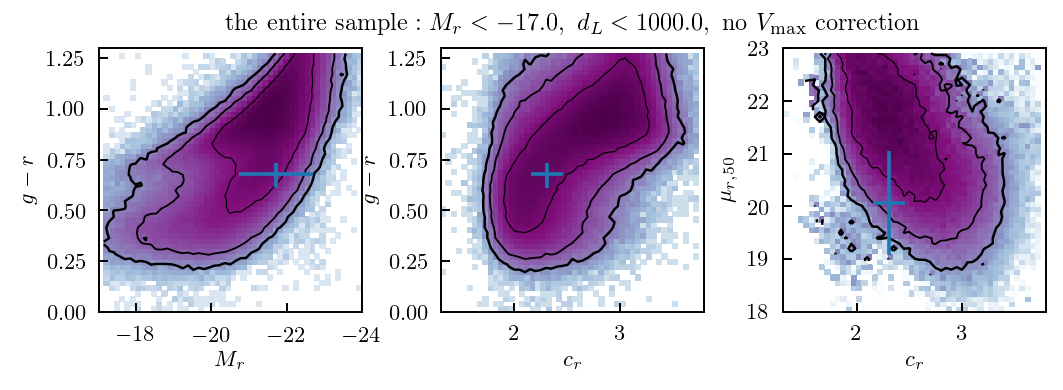

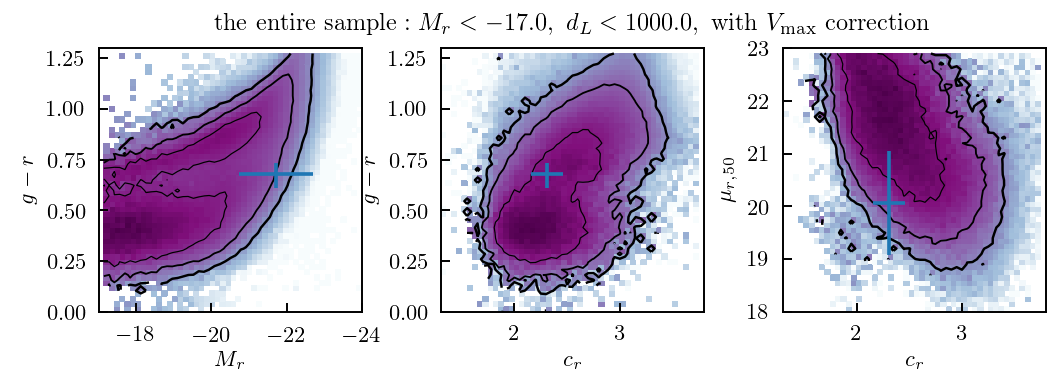

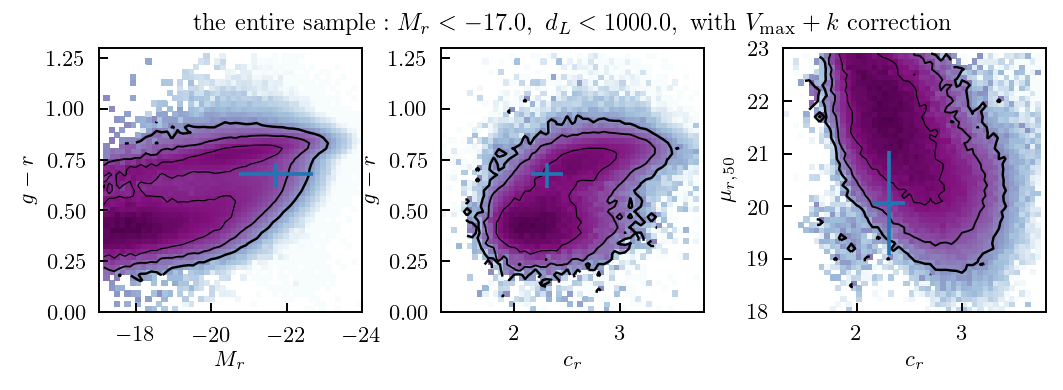

In [195]:
from code.plot_utils import plot_2d_dist

# select a sample of nearby SDSS galaxies down to a given distance and absolute magnitude
Mlim = -17.0; Dmax = 1000.
iloc = (Mcmodel < Mlim) & (d_A < Dmax)
locdata = data[iloc]; M_rl  = Mcmodel[iloc]
zl = locdata['z']
dAl = d_A[iloc]; vmaxiloc = vmaxi[iloc]
grl = locdata['modelMag_g'] - locdata['modelMag_r'] 
kcorr_g = calc_kcor('g', zl, 'g - r', grl)
kcorr_r = calc_kcor('r', zl, 'g - r', grl)
grl_kcorr = grl - kcorr_g + kcorr_r         
r50l = locdata['petroR50_r']; r90l = locdata['petroR90_r']; 
crl = r90l / r50l 
mul = locdata['petroMag_r'] - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(r50l)**2)


#Define here the mean parameters and the errors for the Milky Way

MagMW = -21.72
MagErr = 0.99
muMW = 20.06
muErr = 0.99
giminr = 0.678
giminrup = 0.069
giminrdn = 0.057
concMW = 2.31
concErr = 0.15



Mrlim = [-24.,Mlim]; grlim = [0.,1.3];
crlim = [1.3,3.8]; sblim = [18., 23.]

clevs = [0.68, 0.95, 0.99]

fig, ax = plt.subplots(1,3,figsize=(6., 2.0))
fig.tight_layout()

ax[1].set_title(r'$\mathrm{the\ entire\ sample:}\ M_r<%.1f,\ d_L<%.1f,\ \mathrm{no}\ V_{\rm max}\ \mathrm{correction}$'%(Mlim,Dmax), fontsize=10)


plot_2d_dist(M_rl, grl, Mrlim, grlim, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$M_r$', ylabel=r'$g-r$', fig_setup=ax[0])
ax[0].errorbar([MagMW],[giminr],[[giminrup],[giminrdn]],[MagErr])



plot_2d_dist(crl, grl, crlim, grlim, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$c_r$', ylabel=r'$g-r$', fig_setup=ax[1])
ax[1].errorbar([concMW],[giminr],[[giminrup],[giminrdn]],[concErr])


plot_2d_dist(crl, mul, crlim, sblim,  weights=vmaxiloc, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$c_r$', ylabel=r'$\mu_{r,50}$', fig_setup=ax[2])
ax[2].errorbar([concMW],[muMW],[muErr],[concErr])



plt.show()

fig, ax = plt.subplots(1,3,figsize=(6., 2.0))
fig.tight_layout()

ax[1].set_title(r'$\mathrm{the\ entire\ sample:}\ M_r<%.1f,\ d_L<%.1f, \ \mathrm{with}\ V_{\rm max}\ \mathrm{correction}$'%(Mlim,Dmax), fontsize=10)
plot_2d_dist(M_rl, grl, Mrlim, grlim,  weights=vmaxiloc, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$M_r$', ylabel=r'$g-r$', fig_setup=ax[0])
ax[0].errorbar([MagMW],[giminr],[[giminrup],[giminrdn]],[MagErr])

plot_2d_dist(crl, grl, crlim, grlim,  weights=vmaxiloc, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$c_r$', ylabel=r'$g-r$', fig_setup=ax[1])
ax[1].errorbar([concMW],[giminr],[[giminrup],[giminrdn]],[concErr])



plot_2d_dist(crl, mul, crlim, sblim,  weights=vmaxiloc, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$c_r$', ylabel=r'$\mu_{r,50}$', fig_setup=ax[2])
ax[2].errorbar([concMW],[muMW],[muErr],[concErr])



#plt.savefig('fig/colcrmur.pdf',bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1,3,figsize=(6., 2.0))
fig.tight_layout()

ax[1].set_title(r'$\mathrm{the\ entire\ sample:}\ M_r<%.1f,\ d_L<%.1f, \ \mathrm{with}\ V_{\rm max}+k\ \mathrm{correction}$'%(Mlim,Dmax), fontsize=10)
plot_2d_dist(M_rl, grl_kcorr, Mrlim, grlim,  weights=vmaxiloc, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$M_r$', ylabel=r'$g-r$', fig_setup=ax[0])
ax[0].errorbar([MagMW],[giminr],[[giminrup],[giminrdn]],[MagErr])

plot_2d_dist(crl, grl_kcorr, crlim, grlim,  weights=vmaxiloc, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$c_r$', ylabel=r'$g-r$', fig_setup=ax[1])
ax[1].errorbar([concMW],[giminr],[[giminrup],[giminrdn]],[concErr])



plot_2d_dist(crl, mul - kcorr_r, crlim, sblim,  weights=vmaxiloc, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$c_r$', ylabel=r'$\mu_{r,50}$', fig_setup=ax[2])
ax[2].errorbar([concMW],[muMW],[muErr],[concErr])



#plt.savefig('fig/colcrmur.pdf',bbox_inches='tight')
plt.show()



We see that the Milky Way is intrinsically brighter (absolute magnitude smaller) than most galaxies, and has about average light concentration and color. 

b) Let's try now to repeat part 1, but adding as a restriction that the concentration of light $c_r$ of selected galaxies has to be close to that of the Milky Way.

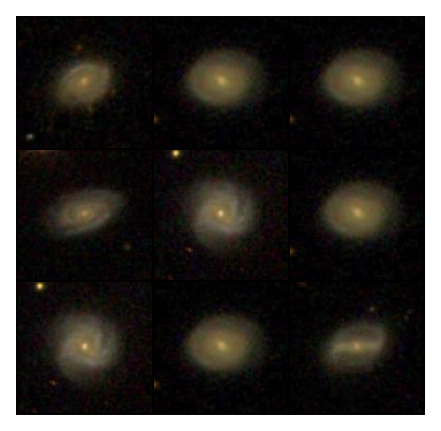

In [196]:
from code.plot_utils import sdss_img_collage

# the number of rows and columns in the image collage
nrow = 3; ncol = 3
# pixel size of the thumbnails to extract from the SDSS
npix = 130

# definition of arcsec 
arcsec = 4.84814e-6


# minimum and maximum luminosity distances for galaxy selection
Dmin = 20.; Dmax = 200.; 
# Limits on absolute r magnitude, color, r_50 -- with proper adjustments, as described above 
Mup = - 19.74
Mlow = - 23.70
grmin = 0.621 
grmax = 0.74
r50min = 4.0
r50max = 4.8
concmax = 2.6
concmin = 2.0

r50 = (r50*arcsec*d_A)*1000



# select galaxies with these distance and absolute magnitude limits
rdata = data[(Mcmodel < Mup) & (Mcmodel > Mlow) & (d_L > Dmin) & (d_L < Dmax) & (gr > grmin) & (gr < grmax) & (r50 > r50min) & (r50 < r50max) & (r90/r50 > concmin) & (r90/r50 < concmax)]
# select a random subset of galaxies from the selected subset
iran = np.random.randint(0., np.size(rdata)-1, nrow*ncol)
# get data for the randomly selected galaxies
dshow = rdata[iran]
objs = dshow['objID']; ras = dshow['ra']; decs = dshow['dec']

# get images (if they are not yet on disk) and display the collage 
sdss_img_collage(objs, ras, decs, nrow, ncol, npix, scale=0.35)

We see that adding the restriction for the selected galaxies to lie in a range in concentration of $\sim$ two standard deviations from the mean value for the Milky Way, we get $\sim$ two different figures repeatidly; that means that the added constraint is  a tight one. We get spiral galaxies, without a bar (depends on the run)(type Sb-Sc -sometimes SBb) without a very bright bulge. 

In order to see how different criteria affect the selected galaxies in the following scripts we keep the restriction on $c_r$ but we drop the restriction in $M_r$, $g-r$ and $r_{50}$ accordingly. 

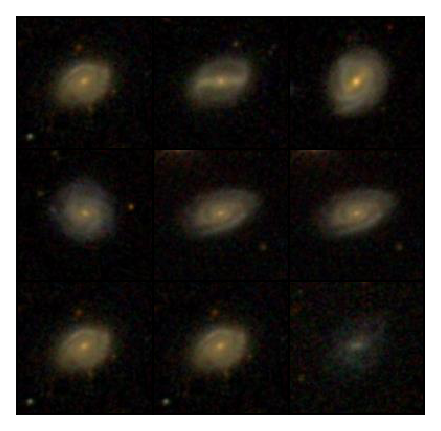

In [197]:
from code.plot_utils import sdss_img_collage


# select galaxies with these distance and absolute magnitude limits
rdata = data[(d_L > Dmin) & (d_L < Dmax) & (gr > grmin) & (gr < grmax) & (r50 > r50min) & (r50 < r50max) & (r90/r50 > concmin) & (r90/r50 < concmax)]
# select a random subset of galaxies from the selected subset
iran = np.random.randint(0., np.size(rdata)-1, nrow*ncol)
# get data for the randomly selected galaxies
dshow = rdata[iran]
objs = dshow['objID']; ras = dshow['ra']; decs = dshow['dec']

# get images (if they are not yet on disk) and display the collage 
sdss_img_collage(objs, ras, decs, nrow, ncol, npix, scale=0.35)



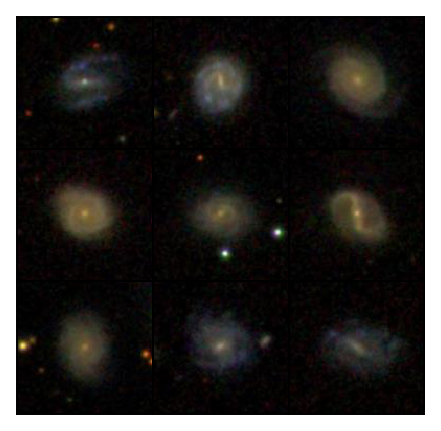

In [198]:
from code.plot_utils import sdss_img_collage


# select galaxies with these distance and absolute magnitude limits
rdata = data[ (Mcmodel < Mup) & (Mcmodel > Mlow) & (d_L > Dmin) & (d_L < Dmax) & (r50 > r50min) & (r50 < r50max) & (r90/r50 > concmin) & (r90/r50 < concmax)]
# select a random subset of galaxies from the selected subset
iran = np.random.randint(0., np.size(rdata)-1, nrow*ncol)
# get data for the randomly selected galaxies
dshow = rdata[iran]
objs = dshow['objID']; ras = dshow['ra']; decs = dshow['dec']

# get images (if they are not yet on disk) and display the collage 
sdss_img_collage(objs, ras, decs, nrow, ncol, npix, scale=0.35)

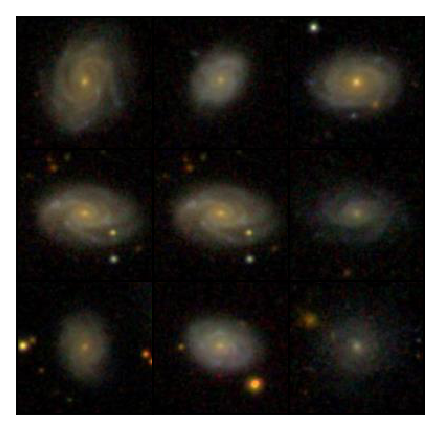

In [199]:
from code.plot_utils import sdss_img_collage


# select galaxies with these distance and absolute magnitude limits
rdata = data[(Mcmodel < Mup) & (Mcmodel > Mlow) & (d_L > Dmin) & (d_L < Dmax) & (gr < grmax) & (r50 > r50min) & (r90/r50 > concmin) & (r90/r50 < concmax)]
# select a random subset of galaxies from the selected subset
iran = np.random.randint(0., np.size(rdata)-1, nrow*ncol)
# get data for the randomly selected galaxies
dshow = rdata[iran]
objs = dshow['objID']; ras = dshow['ra']; decs = dshow['dec']

# get images (if they are not yet on disk) and display the collage 
sdss_img_collage(objs, ras, decs, nrow, ncol, npix, scale=0.35)

From the above we can see that although $c_r$ puts tight constraints, but we can also see that the color $g-r$ puts  very tight constraints as well. When we relax this constraint we see that the sample of galaxies we get has a greater flutiation in their morphological properties.